In [1]:
import numpy as np
import module_multiLayers
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
import json

C:\Users\cdpss\OneDrive - 國立台灣大學\文件\碩一上\光學診斷技術\HW7\module_multiLayers.py:36: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if g is 0:


### Multiple-layer tissue model

#### Develop a multiple layer model and compute R, T and fluence rate distribution for the tissue shown in the diagram below. Let $\Delta$r = $\Delta$z = 0.025 mm. Use variable weight photons and Henyey-Greenstein phase function. Assume the incident light is a collimated beam at normal incidence.

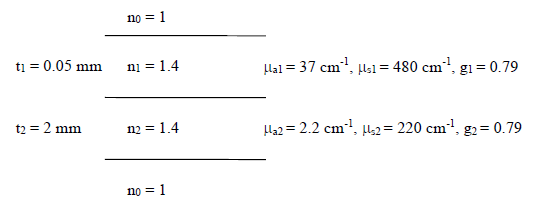

1. Plot the absorption distribution of scattered photons (1/cm$^3$) and the impulse response (infinitely narrow incident beam) for the fluence rate of the scattered photons (1/cm$^2$), both in 2D (r and z).

2. Assume the incident beam having a Gaussian intensity profile with an $e^{-2}$ radius of 0.5 mm and total power of 1W. Plot the fluence rate (W/cm$^2$) in 2D (r and z). Report the total reflectance R (should be approximately 0.21) and the total transmittance T (should be about 0.01).


**問題**
* 之前的作業，如果光子行進到組織外，不用進行路徑長的縮放嗎？ --> 不用，因為光子分裂後，反射回組織內的，ua, us 還是一樣，所以路徑長就是照算(原本穿透組織多少距離，就是返回組織多少距離)，而穿透組織的，就讓它去吧，是 R 就去紀錄 R，是 T 就去紀錄 T
z* 光子在不同組織間穿梭時，被吸收的 mua/(mua+mus) 是要以出發地的參數還是要以目的地的參數做計算？目前的作業先以目的地的作為計算~

In [5]:
####### parameter setting

# mua, mus --> 1/cm;  thickness, depth, distribution_r, grid_width, delta_r, grid_depth, delta_z --> cm; beam_power --> W
with open("hw_7_input.json") as f:
    Tissue_model = json.load(f)

# program repeatedly running times
run_times = 5

Tissue_model

{'Media': [{'mua': 0, 'mus': 0, 'n': 1, 'g': 1, 'name': 'air'},
  {'mua': 37, 'mus': 480, 'n': 1.4, 'g': 0.79, 'name': 'layer_1'},
  {'mua': 2.2, 'mus': 220, 'n': 1.4, 'g': 0.79, 'name': 'layer_2'},
  {'mua': 0, 'mus': 0, 'n': 1, 'g': 1, 'name': 'air'}],
 'Thickness': [0, 0.005, 0.2, 0],
 'Depth': [[-inf, 0], [0, 0.005], [0.005, 0.205], [0.205, inf]],
 'Session': {'beam_power': '1',
  'photon_num': 10000,
  'source': 'Gaussian',
  'distribution_r': 0.05,
  'disappear_weightThreshold': 0.0001,
  'photon_roulettewinning_prob': 0.05,
  'grid_width': 0.2,
  'delta_r': 0.0025,
  'grid_depth': 0.205,
  'delta_z': 0.0025,
  'num_layer': 4}}

In [6]:
# np.random.seed(0)

Run 1 : 100%|████████████████████████████████████████████████████████████████████| 10000/10000 [04:22<00:00, 38.11it/s]


roulette_win_times: 512
R: 0.22062332358953285, T: 0.011680463971103486, A: 0.767691313942996
R+T+A: 0.9999951015036322
Weight in absorption matrix: 0.7526845195528046


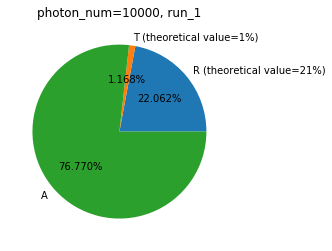

Run 2 : 100%|████████████████████████████████████████████████████████████████████| 10000/10000 [04:35<00:00, 34.58it/s]


roulette_win_times: 551
R: 0.2275382814689951, T: 0.011946457674690958, A: 0.7605190307782781
R+T+A: 1.0000037699219642
Weight in absorption matrix: 0.7463819568921684


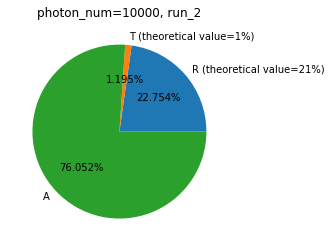

Run 3 : 100%|████████████████████████████████████████████████████████████████████| 10000/10000 [04:40<00:00, 35.62it/s]


roulette_win_times: 554
R: 0.21579208017485435, T: 0.011650483602551933, A: 0.7725596972299359
R+T+A: 1.0000022610073422
Weight in absorption matrix: 0.7568142315265768


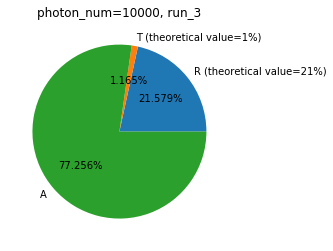

Run 4 : 100%|████████████████████████████████████████████████████████████████████| 10000/10000 [04:42<00:00, 35.44it/s]


roulette_win_times: 530
R: 0.22085522868823504, T: 0.01231062341679688, A: 0.7668322606091325
R+T+A: 0.9999981127141644
Weight in absorption matrix: 0.7519067720323644


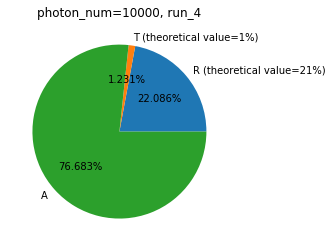

Run 5 : 100%|████████████████████████████████████████████████████████████████████| 10000/10000 [04:44<00:00, 35.94it/s]


roulette_win_times: 551
R: 0.21967900307530663, T: 0.01147118524286849, A: 0.7688547808553486
R+T+A: 1.0000049691735238
Weight in absorption matrix: 0.7540359836837908


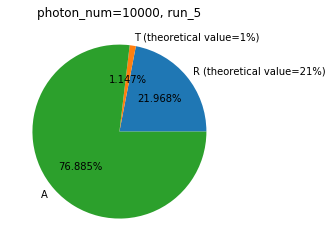

Summary:
R mean = 0.22089758339938478, std = 0.00423458924804118
T mean = 0.01181184278160235, std = 0.00032643836581139194


In [7]:
%matplotlib inline

R_all = np.empty(run_times)
T_all = np.empty(run_times)

for run_index in range(run_times):

    # initialize total absorption, total transmittance, total reflectance, absorption_matrix, roulette_win_times
    A = 0
    T = 0
    R = 0
    absorption_matrix = np.zeros(shape=(int(Tissue_model["Session"]["grid_width"]/Tissue_model["Session"]["delta_r"]), 
                                        int(Tissue_model["Session"]["grid_depth"]/Tissue_model["Session"]["delta_z"])))
    roulette_win_times = 0
    
    # start to run simulation !!
    for photon_index in tqdm(range(Tissue_model["Session"]["photon_num"]), desc="Run {} ".format(run_index+1)):

        # photon initializaion
        new_photon = module_multiLayers.photon(variable_weight=True, 
                                               source_type=Tissue_model["Session"]["source"], 
                                               source_radius=Tissue_model["Session"]["distribution_r"]
                                              )

        # launch the photon (start from z = 0-)
        new_photon.travel(Tissue_model["Media"][1]["mua"], 
                          Tissue_model["Media"][1]["mus"]
                         )
        
        # experience the first reflection
        new_photon.next_layer = new_photon.current_layer + int(np.sign(new_photon.cz)*1)
        transmitted_percentage, reflected_percentage = new_photon.get_boundary_split_ratio(n1=Tissue_model["Media"][new_photon.current_layer]["n"], 
                                                                                           n2=Tissue_model["Media"][new_photon.next_layer]["n"])
        R = R + new_photon.weight*reflected_percentage
        new_photon.weight = new_photon.weight*transmitted_percentage

        # go into the tissue, set the current layer = 1 and photon_AbsSca_index = 0
        new_photon.current_layer = 1
        photon_AbsSca_index = 0
        while True:
            
            # determine if photon is in the same layer
            if Tissue_model["Depth"][new_photon.current_layer][0] <= new_photon.position[2] < Tissue_model["Depth"][new_photon.current_layer][1]: # True --> simulation keep going
                
                # update absorption_matrix, A, W
#                 if photon_AbsSca_index >= 1:
                photon_distance_to_original_axis = np.sqrt(new_photon.position[0]**2 + new_photon.position[1]**2)
                if photon_distance_to_original_axis < Tissue_model["Session"]["grid_width"] and new_photon.position[2] < Tissue_model["Session"]["grid_depth"]:
                    index_r = int(photon_distance_to_original_axis//Tissue_model["Session"]["delta_r"])
                    index_z = int(new_photon.position[2]//Tissue_model["Session"]["delta_z"])
                    absorption_matrix[index_r][index_z] = absorption_matrix[index_r][index_z] + new_photon.weight*Tissue_model["Media"][new_photon.current_layer]["mua"]/(Tissue_model["Media"][new_photon.current_layer]["mua"]+Tissue_model["Media"][new_photon.current_layer]["mus"])

                A = A + new_photon.weight*Tissue_model["Media"][new_photon.current_layer]["mua"]/(Tissue_model["Media"][new_photon.current_layer]["mua"]+Tissue_model["Media"][new_photon.current_layer]["mus"])
                new_photon.weight = new_photon.weight*Tissue_model["Media"][new_photon.current_layer]["mus"]/(Tissue_model["Media"][new_photon.current_layer]["mua"]+Tissue_model["Media"][new_photon.current_layer]["mus"])
                photon_AbsSca_index += 1
                
                # check if weight is too small ?
                if new_photon.weight > Tissue_model["Session"]["disappear_weightThreshold"]:
                    new_photon.scattering(Tissue_model["Media"][new_photon.current_layer]["g"])
                    new_photon.travel(Tissue_model["Media"][new_photon.current_layer]["mua"], Tissue_model["Media"][new_photon.current_layer]["mus"])
                else:
                    new_photon.play_roulette(Tissue_model["Session"]["photon_roulettewinning_prob"])
                    if new_photon.weight == 0:
                        break # -> next photon
                    else:
                        roulette_win_times += 1
                        new_photon.scattering(Tissue_model["Media"][new_photon.current_layer]["g"])
                        new_photon.travel(Tissue_model["Media"][new_photon.current_layer]["mua"], Tissue_model["Media"][new_photon.current_layer]["mus"])

            else: # False --> photon not in the current layer
                # know next layer
                new_photon.next_layer = new_photon.current_layer + int(np.sign(new_photon.cz)*1)
                
                if Tissue_model["Media"][new_photon.next_layer]["name"] == "air":                
                    transmitted_percentage, reflected_percentage = new_photon.get_boundary_split_ratio(n1=Tissue_model["Media"][new_photon.current_layer]["n"], 
                                                                                                       n2=Tissue_model["Media"][new_photon.next_layer]["n"])
                    if new_photon.position[2] < Tissue_model["Depth"][0][1]: # update R
                        # collect photon weight back to surface from tissue
                        R = R + new_photon.weight*transmitted_percentage
                        new_photon.weight = new_photon.weight*reflected_percentage
                    else:                          # update T
                        # collect photon weight transmitting to lower air layer
                        T = T + new_photon.weight*transmitted_percentage
                        new_photon.weight = new_photon.weight*reflected_percentage
                    # doing reflection
                    new_photon.reflect_updatePosDir(Tissue_model)
                    
                else:
                    if Tissue_model["Media"][new_photon.current_layer]["n"] == Tissue_model["Media"][new_photon.next_layer]["n"]:
                        new_photon.transmit_updatePosDir(Tissue_model)
                    else:
                        transmitted_percentage, reflected_percentage = new_photon.get_boundary_split_ratio(n1=Tissue_model["Media"][new_photon.current_layer]["n"], 
                                                                                                           n2=Tissue_model["Media"][new_photon.next_layer]["n"])
                        if np.random.uniform() < reflected_percentage:
                            # doing reflection
                            new_photon.reflect_updatePosDir(Tissue_model)
                        else:
                            # doing refraction
                            new_photon.refract_updatePosDir(Tissue_model)
                    

    print("roulette_win_times:", roulette_win_times)
    print("R: {}, T: {}, A: {}".format(R/Tissue_model["Session"]["photon_num"], 
                                                T/Tissue_model["Session"]["photon_num"], 
                                                A/Tissue_model["Session"]["photon_num"]))
    print("R+T+A:", (R+T+A)/Tissue_model["Session"]["photon_num"])
    print("Weight in absorption matrix:", absorption_matrix.sum()/Tissue_model["Session"]["photon_num"])
    
    # plot the graph (R, T, A pie chart)
    plt.pie([R, T, A], labels=["R (theoretical value=21%)", "T (theoretical value=1%)", "A"], autopct='%1.3f%%')
    title = "photon_num={}, run_{}".format(Tissue_model["Session"]["photon_num"], run_index+1)
    plt.title(title)
#     plt.savefig("hw_4\{}.png".format(title), bbox_inches = "tight")
    plt.show()
    
#     # calculte and plot fluence rate
#     module_multiLayers.calculate_fluenceRate_andPlotHist3D(tissue_model=Tissue_model, 
#                                                      absorption_matrix=absorption_matrix, 
#                                                      plotAbsorptionMatrix=True
#                                                     )
    
    # store the R, T in the current time
    R_all[run_index] = R/Tissue_model["Session"]["photon_num"]
    T_all[run_index] = T/Tissue_model["Session"]["photon_num"]
    
print("==========================================")
print("Summary:")
print("R mean = {}, std = {}".format(R_all.mean(), R_all.std(ddof=1)))
print("T mean = {}, std = {}".format(T_all.mean(), T_all.std(ddof=1)))

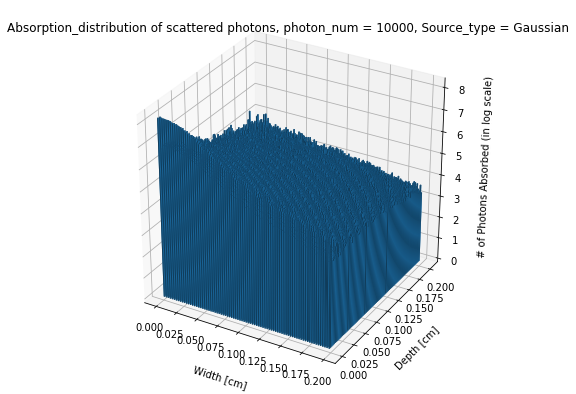

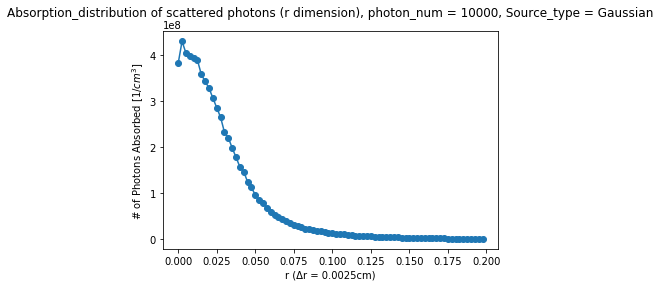

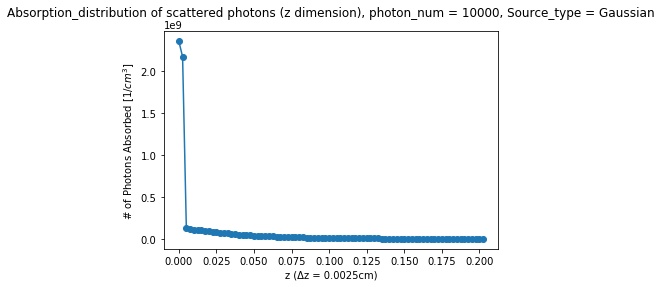

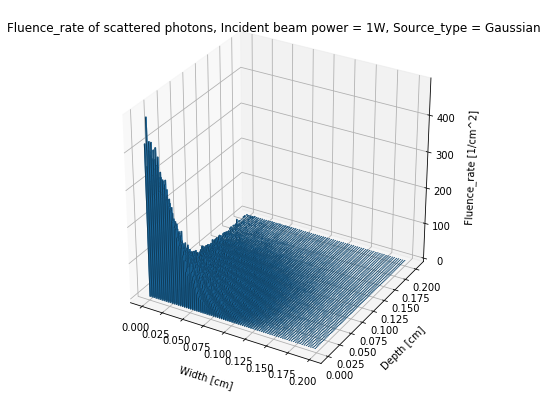

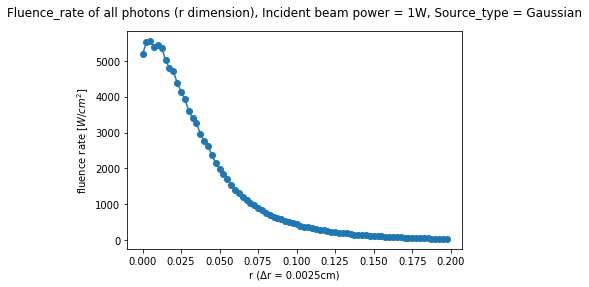

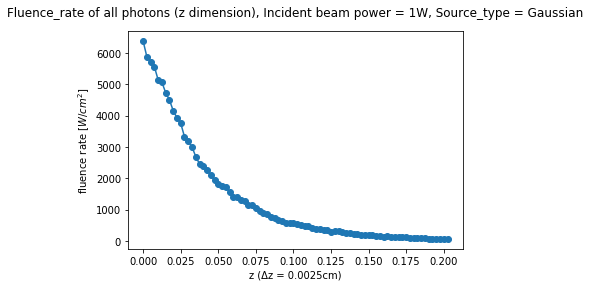

In [15]:
%matplotlib inline
calculate_fluenceRate_andPlotHist3D(tissue_model=Tissue_model, 
                                                     absorption_matrix=absorption_matrix, 
                                                     plotAbsorptionMatrix=True
                                                    )

In [2]:
def calculate_fluenceRate_andPlotHist3D(tissue_model, absorption_matrix, plotAbsorptionMatrix=False):
    grid_width = tissue_model["Session"]["grid_width"]
    grid_depth = tissue_model["Session"]["grid_depth"]
    delta_r = tissue_model["Session"]["delta_r"]
    delta_z = tissue_model["Session"]["delta_z"]
    photon_num = tissue_model["Session"]["photon_num"]
    source_type = tissue_model["Session"]["source"]
    beam_power = tissue_model["Session"]["beam_power"]
    
    # plot absorption_matrix (per volume -- 1/cm^3)
    if plotAbsorptionMatrix:
        # transform to per volume
        absorption_matrix_V = np.empty_like(absorption_matrix)
        for i_r in range(int(grid_width/delta_r)):
            V_i_r = (2*i_r+1) * np.pi * delta_z * (delta_r**2)  # cm^3
            for i_z in range(int(grid_depth/delta_z)):
                absorption_matrix_V[i_r][i_z] = absorption_matrix[i_r][i_z]/V_i_r
        absorption_matrix_log = np.ma.log10(absorption_matrix_V).filled(0)
        
        # plot bar3D
        fig = plt.figure(figsize=(7, 7))
        ax = fig.add_subplot(111, projection='3d')
        R_grid, Z_grid = np.meshgrid(np.arange(grid_width/delta_r), np.arange(grid_depth/delta_z))

        x_pos = R_grid.T.ravel()*delta_r
        y_pos = Z_grid.T.ravel()*delta_z
        z_pos = 0

        dx = delta_r/2 * np.ones_like(z_pos)
        dy = delta_z/2 * np.ones_like(z_pos)
        dz = absorption_matrix_log.ravel()

        ax.bar3d(x_pos, y_pos, z_pos, dx, dy, dz, shade=True)
        ax.set_xlabel('Width [cm]', labelpad=10); 
        ax.set_ylabel('Depth [cm]', labelpad=10); 
        ax.set_zlabel('# of Photons Absorbed (in log scale)', labelpad=10);
        ax.set_title("Absorption_distribution of scattered photons, photon_num = {}, Source_type = {}".format(photon_num, source_type))
        plt.show()
        
        # plot 2D (with r & z)
        R = np.arange(0, grid_width, delta_r)
        Z = np.arange(0, grid_depth, delta_z)
        plt.plot(R, absorption_matrix_V.sum(axis=1), '-o')
        plt.xlabel("r (\u0394r = {}cm)".format(delta_r))
        plt.ylabel("# of Photons Absorbed [$1/cm^3$]")
        plt.title("Absorption_distribution of scattered photons (r dimension), photon_num = {}, Source_type = {}".format(photon_num, source_type), pad = 15)
        plt.show()
        plt.plot(Z, absorption_matrix_V.sum(axis=0), '-o')
        plt.xlabel("z (\u0394z = {}cm)".format(delta_z))
        plt.ylabel("# of Photons Absorbed [$1/cm^3$]")
        plt.title("Absorption_distribution of scattered photons (z dimension), photon_num = {}, Source_type = {}".format(photon_num, source_type), pad = 15)
        plt.show()
        
    # calculte fluence rate for the given beam power (default = 1W)
    absorption_matrix_VN = np.empty_like(absorption_matrix)
    for i_r in range(int(grid_width/delta_r)):
        V_i_r = (2*i_r+1) * np.pi * delta_z * (delta_r**2)  # cm^3
        for i_z in range(int(grid_depth/delta_z)):
            absorption_matrix_VN[i_r][i_z] = absorption_matrix[i_r][i_z]/(V_i_r*photon_num)
    fluence_rate = np.empty_like(absorption_matrix_VN)
    for tissue_layer in range(1, tissue_model["Session"]["num_layer"]-1):
        start = int(tissue_model["Depth"][tissue_layer][0]/delta_z)
        end = int(tissue_model["Depth"][tissue_layer][1]/delta_z)
        fluence_rate[:, start:end] = absorption_matrix_VN[:, start:end]/tissue_model["Media"][tissue_layer]["mua"]
    fluence_rate = fluence_rate * float(beam_power)
    
    # plot fluence rate 3D plot
    fig = plt.figure(figsize=(7, 7))
    ax = fig.add_subplot(111, projection='3d')
    R_grid, Z_grid = np.meshgrid(np.arange(grid_width/delta_r), np.arange(grid_depth/delta_z))
    
    x_pos = R_grid.T.ravel()*delta_r
    y_pos = Z_grid.T.ravel()*delta_z
    z_pos = 0
    
    dx = delta_r/2 * np.ones_like(z_pos)
    dy = delta_z/2 * np.ones_like(z_pos)
    dz = fluence_rate.ravel()
    
    ax.bar3d(x_pos, y_pos, z_pos, dx, dy, dz, shade=True)
    ax.set_xlabel('Width [cm]', labelpad=10)
    ax.set_ylabel('Depth [cm]', labelpad=10)
    ax.set_zlabel('Fluence_rate [1/cm^2]', labelpad=10)
    ax.set_title("Fluence_rate of scattered photons, Incident beam power = {}W, Source_type = {}".format(beam_power, source_type))
    plt.show()
    
    # plot 2D (with r & z)
    R = np.arange(0, grid_width, delta_r)
    Z = np.arange(0, grid_depth, delta_z)
    plt.plot(R, fluence_rate.sum(axis=1), '-o')
    plt.xlabel("r (\u0394r = {}cm)".format(delta_r))
    plt.ylabel("fluence rate [$W/cm^2$]")
    plt.title("Fluence_rate of all photons (r dimension), Incident beam power = {}W, Source_type = {}".format(beam_power, source_type), pad = 15)
#     plt.title("Fluence_rate of scattered photons, Incident beam power = {}W, Source_type = {}".format(beam_power, source_type))
    plt.show()
    plt.plot(Z, fluence_rate.sum(axis=0), '-o')
    plt.xlabel("z (\u0394z = {}cm)".format(delta_z))
    plt.ylabel("fluence rate [$W/cm^2$]")
    plt.title("Fluence_rate of all photons (z dimension), Incident beam power = {}W, Source_type = {}".format(beam_power, source_type), pad = 15)
#     plt.title("Fluence_rate of scattered photons, Incident beam power = {}W, Source_type = {}".format(beam_power, source_type))
    plt.show()